# running Region Based Analysis (RBA) - an hierarchical mixed effects models on the whole brain (aka a set of ROIs)

A notebook to run an RBA on fMRI data.  
OHBM Brainhack 2022 project  

Authors:  
Gang Chen [@afni-gangc](https://github.com/afni-gangc)  
Christopher Nolan [@crnolan](https://github.com/crnolan)    
Kelly Garner  [@kel-github](https://github.com/kel-github) 
Lea Waller  [@HippocampusGirl](https://github.com/HippocampusGirl)  
Daniel Tomasz [@danieltomasz](https://github.com/danieltomasz)  

Modelling task-based fMRI data often involves performing a GLM at each voxel and then correcting for many many many multiple comparisons.  

Here instead, we first summarise the data at the region of interest (ROI) level, and then perform a single hierarchical mixed effects model on all the ROIs at once.  

This provides advantages typical of Bayesian hiearchal modelling; information at upper levels of the hierarchy (e.g. across ROIs) can help inform estimates at lower levels (the estimate for each ROI) - aka shrinkage - and we avoid the multiple comparisons problem by instead providing the strength of evidenve for the effect of interest at each ROI.  

For a comprehensive introduction to this approach, see [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6635105/) and [this paper](https://apertureneuropub.cloud68.co/articles/46/index.html) by Gang Chen.

## Running the Notebook

We assume that you have followed the installation instructions detailed in the repo [ReadMe](https://github.com/crnolan/pyrba/blob/main/README.md) doc.  

**What we assume has happened before now**  

You have run an experiment manipulating or measuring a particular variable. For our example we are assuming we have collected theory of mind (ToM) measures and have fMRI data from participants performing a task.  

We want to know the association between ToM and activity in each of our ROIs. We perform a first-level analysis for each participant x voxel, and then for each ROI we average the effect of interest (e.g. a beta-coefficient or correlation score) across voxels.  

This produces a dataset containing the following fields:  

subject | ROI | y | x  

- x:  predictor variable (in this example a theory of mind score) (float)  
- y = DV of interest from first level analysis - e.g. mu beta coefficient from region of interest (ROI) (float)  
- ROI: the name of the region of interest (ROI) (string)  
- subject: ID (string) 

### load required modules

In [1]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import bambi as bmb
sns.set_theme(style='white')

<Figure size 432x288 with 0 Axes>

### next we load the data  

We have a nice small set in the repo called 'data.txt' that you can try this on  

In [2]:
df = pd.read_csv('data.txt', delimiter = '\s')
df.head(5)

/tmp/ipykernel_13431/1638352057.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('data.txt', delimiter = '\s')


,subject,ROI,y,x
0,HMN001,RPCC,0.3457,17.76
1,HMN002,RPCC,0.5166,17.05
2,HMN003,RPCC,0.0919,15.81
3,HMN004,RPCC,0.3635,15.19
4,HMN005,RPCC,0.7323,17.31


Next we define the model. Luckily for us, Tal Yarkoni & Jake Westfall developed this awesome [Bambi package](https://osf.io/rv7sn) which allows us to specify our linear mixed effects model using the notation we know so well in the neurosciences and social sciences more broadly (If you don't know the notation then see [this excellent introduction](https://bodo-winter.net/tutorial/bw_LME_tutorial2.pdf) from Bodo Winter). The package takes our formula and specifies our model in [PyMC](https://www.pymc.io/welcome.html) parlance, ready for passing to PyMC.  

We define a model where our data (_y_) is predicted by our ToM measure (_x_), an intercept for each subject (_(1|subject)_), and a ToM x ROI interaction (_(x|ROI)_).

In [3]:
model = bmb.Model("y ~ x + (1|subject) + (x|ROI)", data=df)

We then fit the model using PyMC. We are going to use the default priors (see the model graph below), and the No U-Turn Sampler ([NUTS](https://arxiv.org/abs/1111.4246)). 



In [4]:
fitted = model.fit(tune=4000, 
                   draws=1000, 
                   chains=16, 
                   method='nuts_numpyro',
                   nuts_kwargs=dict(max_tree_depth=100))

/home/cnolan/miniconda3/envs/pyrba/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/home/cnolan/miniconda3/envs/pyrba/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...
Compilation time =  0:00:13.497835
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:04:57.699606
Transforming variables...
Transformation time =  0:00:00.124161
Computing Log Likelihood...
Log Likelihood time =  0:00:39.889620


A nice feature of PyMC is that we can easily print the model graph, which shows us the assumptions we've made about the parameters in our model.  

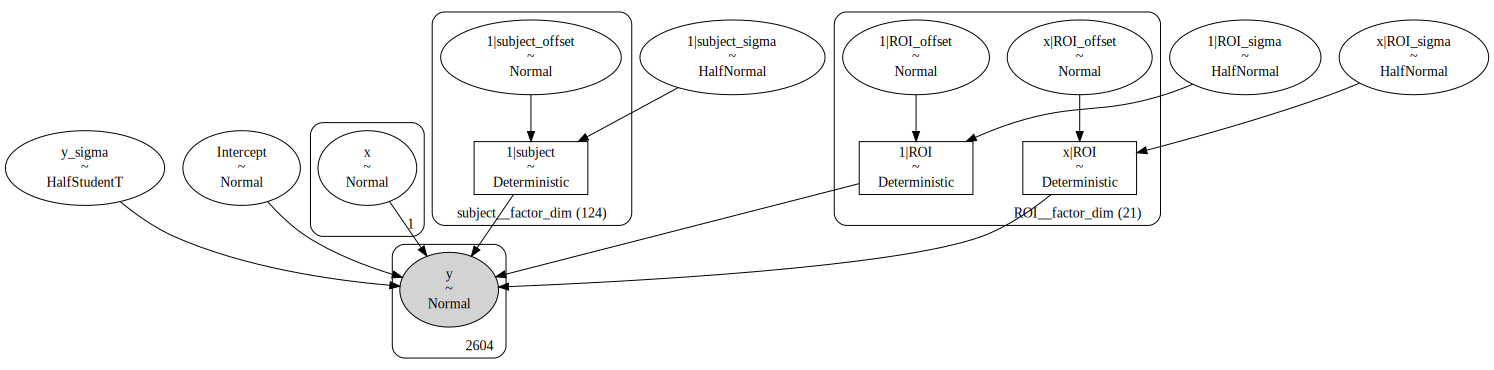

In [5]:
model.graph()

As you can see above, we assume that the random effects from the model come from normal distributions whose variance is drawn from a half normal (note this deviates from the original implementation in R, but we are working on this). Next we plot the psoterior estimates, and the chains to check that the model converged.  

We also print out a summary of the model. We want to check the $\hat{R}$ is around 1.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.052,0.064,-0.064,0.176,0.001,0.001,5429.0,8853.0,1.0
x,0.007,0.004,-0.001,0.015,0.000,0.000,4892.0,7809.0,1.0
1|subject_sigma,0.077,0.006,0.066,0.088,0.000,0.000,4656.0,6976.0,1.0
1|ROI_sigma,0.075,0.033,0.007,0.133,0.001,0.000,3295.0,3649.0,1.0
x|ROI_sigma,0.009,0.002,0.005,0.012,0.000,0.000,6918.0,9636.0,1.0
...,...,...,...,...,...,...,...,...,...
x|ROI[RTPJp],0.021,0.006,0.010,0.032,0.000,0.000,4053.0,6930.0,1.0
x|ROI[RvBG],-0.003,0.004,-0.010,0.004,0.000,0.000,9787.0,9887.0,1.0
x|ROI[SGC],-0.004,0.004,-0.011,0.004,0.000,0.000,9283.0,10803.0,1.0
x|ROI[dmMPFC],0.002,0.004,-0.005,0.009,0.000,0.000,9199.0,10090.0,1.0


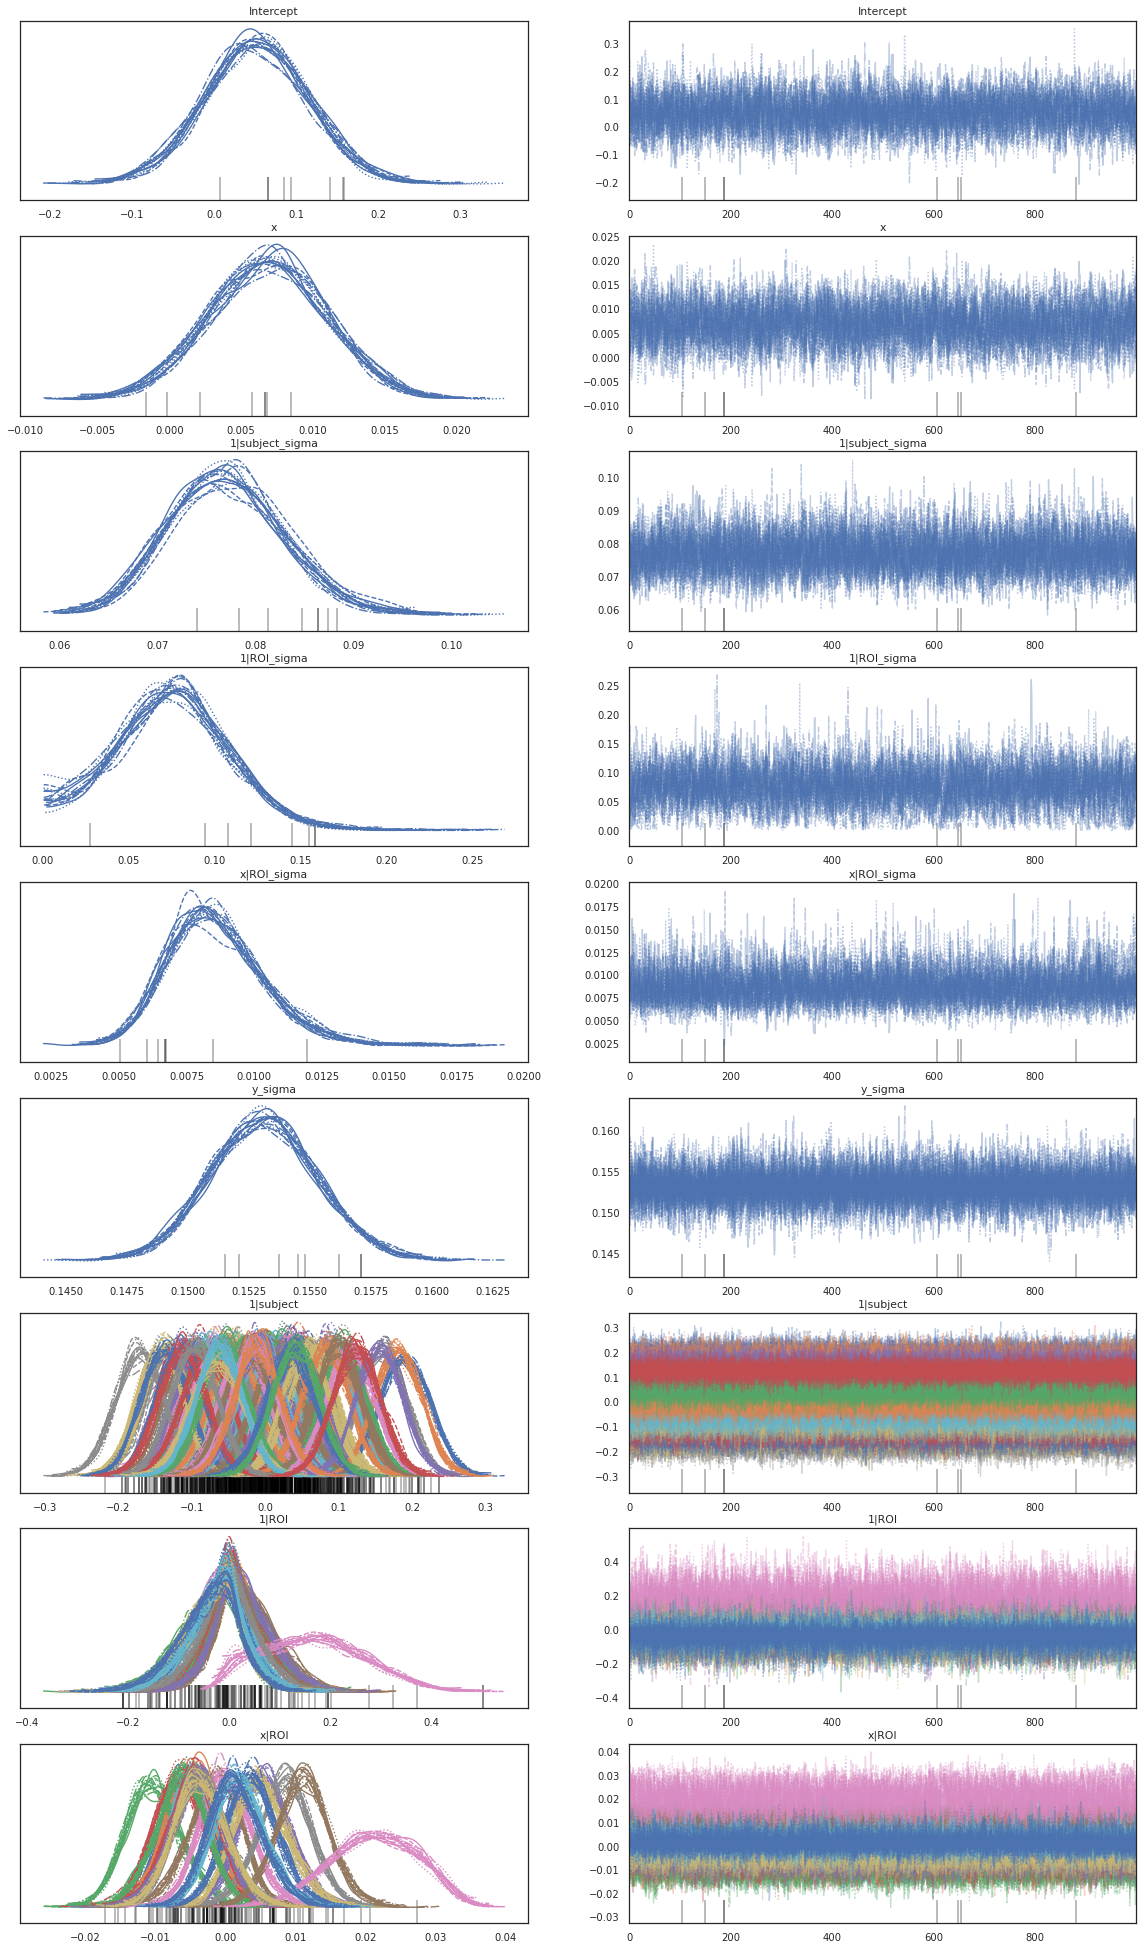

In [6]:
az.plot_trace(fitted, figsize=(20, 35))
az.summary(fitted)

We now want to check the results look somewhat like the output from Gang's original R implementation, so what follows is some data-wrangling and then a plot comparison...

In [7]:
rois = fitted['posterior']['x|ROI'] + fitted['posterior']['x']
rois = rois.stack(y=['draw', 'chain']).to_pandas().transpose()
rois.columns.name = 'ROI'
rois = rois.stack()
rois.name = 'value'
rois

draw  chain  ROI       
0     0      ACC          -0.008814
             LAmy/Hippo   -0.003481
             LCing        -0.013603
             LIFG         -0.008911
             LIPL          0.003222
                             ...   
999   15     RTPJp         0.029457
             RvBG          0.002956
             SGC           0.006454
             dmMPFC        0.013295
             vmPFC         0.012149
Name: value, Length: 336000, dtype: float64

In [8]:
roi_means = rois.groupby(['ROI']).mean().sort_values(ascending=False)

In [9]:
roi_df = rois.to_frame()
roi_df['roi_mean'] = roi_df.groupby(['ROI']).transform('mean')
roi_df

value  roi_mean
draw chain ROI                           
0    0     ACC        -0.008814  0.001742
           LAmy/Hippo -0.003481  0.001712
           LCing      -0.013603 -0.003298
           LIFG       -0.008911  0.000385
           LIPL        0.003222  0.012681
...                         ...       ...
999  15    RTPJp       0.029457  0.028148
           RvBG        0.002956  0.003404
           SGC         0.006454  0.003318
           dmMPFC      0.013295  0.008912
           vmPFC       0.012149  0.008381

[336000 rows x 2 columns]

The color codes the P+ value: the posterior probability of the effect being positive, which is also the area under the posterior density above 0 (the dashed line). 

In [10]:
pos = lambda col : (col[col > 0].sum())/sum(abs(col))
roi_df = rois.to_frame()
roi_df['Pplus'] = roi_df.groupby(['ROI']).transform(pos)
roi_df

value     Pplus
draw chain ROI                           
0    0     ACC        -0.008814  0.711665
           LAmy/Hippo -0.003481  0.707171
           LCing      -0.013603  0.160570
           LIFG       -0.008911  0.548972
           LIPL        0.003222  0.999279
...                         ...       ...
999  15    RTPJp       0.029457  1.000000
           RvBG        0.002956  0.855822
           SGC         0.006454  0.846204
           dmMPFC      0.013295  0.992615
           vmPFC       0.012149  0.990057

[336000 rows x 2 columns]

/home/cnolan/miniconda3/envs/pyrba/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/cnolan/miniconda3/envs/pyrba/lib/python3.10/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


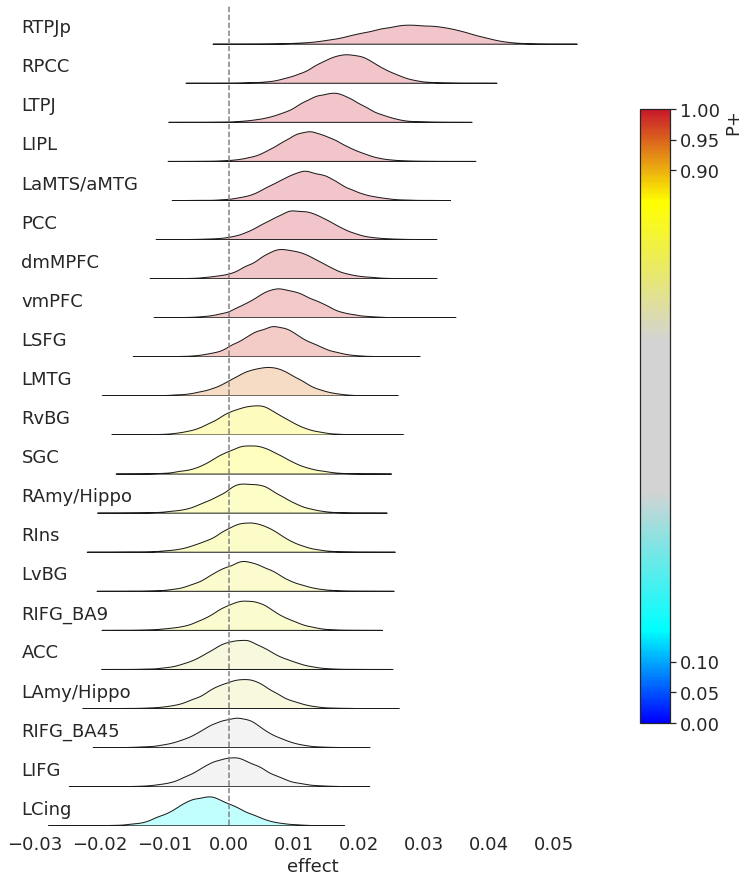

In [14]:
colors = ["blue","cyan","lightgray","lightgray","yellow","#C9182B"]
values = np.array([0, 0.15, 0.375, 0.625, 0.85, 1])
cmap = LinearSegmentedColormap.from_list("gangchen", list(zip(values, colors)))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
# matplotlib.cm.register_cmap("sm", sm.cmap)
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rcParams['font.weight'] = 'normal'
g = sns.displot(roi_df.reset_index(),
                x='value',
                hue='Pplus',
                hue_norm=(0, 1),
                row='ROI',
                kind='kde',
                legend=False,
                row_order=roi_means.index,
                fill=True,
                edgecolor='k',
                palette=sns.color_palette(cmap, n_colors=len(colors), as_cmap=True),
                height=0.6,
                aspect=18)
g.refline(x=0.0)
g.set_axis_labels(x_var='effect', y_var='')
g.set_titles(template='', row_template='{row_name}')
g.set_yticklabels(labels=[])
sns.despine(left=True, bottom=True)
g.tight_layout()
plt.subplots_adjust(hspace=0.05)
axes = g.axes.ravel()
for i, (label, ax, mean) in enumerate(zip(roi_means.index, axes, roi_means)):
    ax.set_title(label, loc="left", pad=-26)
g.figure.colorbar(sm, ax=axes[:], shrink=0.75, location='right', ticks=[0.0, 0.05, 0.1, 0.9, 0.95, 1.0]).set_label('P+', loc='top')
g.figure.savefig('pymc_posteriors.pdf')